## Exploratory Data Analysis (EDA)

Este notebook apresenta a análise exploratória realizada no conjunto de dados de treinamento para o problema de identificação de Fake News, problema abordado nesse projeto.

#### Versão do Python:

In [27]:
from platform import python_version

print('Versão do Python: ' + python_version())

Versão do Python: 3.7.1


#### Importação de bibliotecas:

In [28]:
import pandas as pd
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


#### Importação e visão geral do conjunto de treinamento:

In [29]:
# read datasets
train = pd.read_csv('dataset/train.csv')
print("Existem {} exemplo, no dataset de treinamento. Cada exemplo contém {} atributos, sendo: "
      .format(train.shape[0],train.shape[1]) + ", ".join(train.columns) + '.')

Existem 20800 exemplo, no dataset de treinamento. Cada exemplo contém 5 atributos, sendo: id, title, author, text, label.


In [30]:
# visualização das 5 primeiras notícias do conjunto de dados
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1


In [31]:
# informações adicionais sobre o conjunto de treinamento
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
id        20800 non-null int64
title     20242 non-null object
author    18843 non-null object
text      20761 non-null object
label     20800 non-null int64
dtypes: int64(2), object(3)
memory usage: 568.8+ KB


In [32]:
print('Existem {} exemplos onde o atributo title é nulo.'.format(len(train[train['title'].isnull()])))
print('Existem {} exemplos onde o atributo author é nulo.'.format(len(train[train['author'].isnull()])))
print('Existem {} exemplos onde o atributo text é nulo.'.format(len(train[train['text'].isnull()])))

Existem 558 exemplos onde o atributo title é nulo.
Existem 1957 exemplos onde o atributo author é nulo.
Existem 39 exemplos onde o atributo text é nulo.


Como é possível notar acima, existem 39 casos em que o texto da reportagem é nulo. Esses casos serão removidos do conjunto de treinamento.

In [33]:
# remover exemplos com texto vazio
train = train[~train['text'].isnull()]
train.shape

(20761, 5)

In [34]:
print("Existem {} textos únicos no conjunto de dados, sendo assim {} duplicados. Esses exemplos duplicados serão removidos,\
 sendo mantido o primeiro exemplo de cada item duplicado."
     .format(len(train['text'].unique()),len(train['text'])-len(train['text'].unique())))
train.drop_duplicates(subset=['text'],inplace=True)

Existem 20386 textos únicos no conjunto de dados, sendo assim 375 duplicados. Esses exemplos duplicados serão removidos, sendo mantido o primeiro exemplo de cada item duplicado.


In [35]:
print("Com relação à variável resposta, temos {} possíveis respostas. Conforme descrito na proposta desse projeto, \
esse problema é de classificação binária, tendo como objetivo identificar notícias confiáveis \
(representadas pela label 1) e não confiáveis (representadas pela label 0). A distribuição de exemplos em cada classe \
está na tabela abaixo.".format(len(train.label.unique())))


Com relação à variável resposta, temos 2 possíveis respostas. Conforme descrito na proposta desse projeto, esse problema é de classificação binária, tendo como objetivo identificar notícias confiáveis (representadas pela label 1) e não confiáveis (representadas pela label 0). A distribuição de exemplos em cada classe está na tabela abaixo.


In [36]:
# descreve a quantidade de notícias por classe e a proporção que ela representa no conjunto de dados
pd.concat([train['label'].value_counts(),train['label'].value_counts(normalize=True)*100], axis=1, keys=['qtd', '%'])

,qtd,%
0,10387,50.951633
1,9999,49.048367


A partir da tabela acima é possível concluir que o conjunto de dados é balanceado.

#### Análises exploratórias:

In [37]:
print(f"Também é possível identificar que existem ao todo {len(train.author.unique())} autores de \
notícias no conjunto de treinamento.")

Também é possível identificar que existem ao todo 4191 autores de notícias no conjunto de treinamento.


A tabela abaixo contém os nomes dos autores com mais de 100 notícias escritas. Na segunda posição é possível identificar "admin" como autor, o que indica que existem 193 notícias cujos autores podem ser diferentes, pois o dado aparenta estar faltando.

In [38]:
grouped = train.groupby('author')['id'].agg(['count']).reset_index()
grouped[grouped['count']>=100].sort_values('count', ascending=False)

,author,count
2939,Pam Key,243
3918,admin,188
1757,Jerome Hudson,166
721,Charlie Spiering,141
1852,John Hayward,140
2085,Katherine Rodriguez,124
3834,Warner Todd Huston,122
1515,Ian Hanchett,119
576,Breitbart News,118
909,Daniel Nussbaum,112


É possível também analisar os autores que possuem mais notícias confiáveis e aqueles que possuem mais notícias não confiáveis, conforme apresentado nas tabelas abaixo

In [39]:
trust_grouped = train[train['label']==1].groupby('author')['id'].agg(['count']).reset_index()
trust_grouped.sort_values('count', ascending=False)[:10]

,author,count
1699,admin,188
521,Eddy Lavine,85
1465,Starkman,84
58,Alex Ansary,82
629,Gillian,81
522,Editor,81
1850,noreply@blogger.com (Alexander Light),80
432,Dave Hodges,76
706,IWB,73
1530,The European Union Times,73


In [40]:
nottrust_grouped = train[train['label']==0].groupby('author')['id'].agg(['count']).reset_index()
nottrust_grouped.sort_values('count', ascending=False)[:10]

,author,count
1732,Pam Key,242
949,Jerome Hudson,166
387,Charlie Spiering,141
997,John Hayward,140
1156,Katherine Rodriguez,124
2190,Warner Todd Huston,122
808,Ian Hanchett,119
311,Breitbart News,118
491,Daniel Nussbaum,112
5,AWR Hawkins,107


Novamente houve destaque para o autor identificado como admin, sendo o que possui todos os artigos considerados confiáveis e é também o que mais possui artigos confiáveis.
Por outro lado, todos os demais autores com mais artigos escritos são também os autores com mais artigos não confiáveis.

Como variáveis adicionais, serão criadas as colunas de tamanho do texto e quantidade de palavras originais, isto é, antes da etapa de pré-processamento.

In [41]:
train['text_len'] = train['text'].astype(str).apply(len)
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
train['title_len'] = train['title'].astype(str).apply(len)
train['title_word_count'] = train['title'].apply(lambda x: len(str(x).split()))
train.head()

,id,title,author,text,label,text_len,word_count,title_len,title_word_count
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4940,820,81,14
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160,710,55,9
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7714,1266,33,7
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3249,557,63,10
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1,942,154,93,14


### Tratamento dos dados
Nessa etapa será realizado o tratamento inicial dos dados para possibilitar outras análises exploratórias.

##### Conversão para minúsculas

In [43]:
train['processed_text'] = train['text'].str.lower()
train['processed_title'] = train['title'].str.lower()

In [44]:
train['processed_text'][:10]

0    house dem aide: we didn’t even see comey’s let...
1    ever get the feeling your life circles the rou...
2    why the truth might get you fired october 29, ...
3    videos 15 civilians killed in single us airstr...
4    print \r\nan iranian woman has been sentenced ...
5    in these trying times, jackie mason is the voi...
6    ever wonder how britain’s most iconic pop pian...
7    paris  —   france chose an idealistic, traditi...
8    donald j. trump is scheduled to make a highly ...
9    a week before michael t. flynn resigned as nat...
Name: processed_text, dtype: object

##### Remoção de números, caracteres especiais e stop_words

In [ ]:
# retira os caracteres numéricos 
train['processed_text'] = train['processed_text'].str.replace('[0-9]', '',regex=True)
train['processed_title'] = train['processed_title'].str.replace('[0-9]', '',regex=True)


In [ ]:
# retira os caracteres especiais
train['processed_text'] = train['processed_text'].str.replace('[!%&/\\.,®€™()]', '',regex=True)
train['processed_title'] = train['processed_title'].str.replace('[!%&/\\.,®€™()]', '',regex=True)

In [ ]:
train['processed_text'][:10]

In [ ]:
# criar title_len e title_word_count originais e depois de pre-processado
# distribuição de text_len por classe original (idem pro title)
# distribuição de word_count por classe original (idem pro title)
# distribuição de text_len e word_count por classe depois do pre-processamento (idem pro title)
# box_plot do text_len e word_count depois do pre-processamento (idem pro title)
# identificar textos duplicados 
# nuvem de palavras geral e por classe
# 10 palavras mais utilizadas por classe
# palavras que aparecem em apenas uma notícia
# palavras que estão apenas em uma das classes (mais frequentes e únicas)
# 


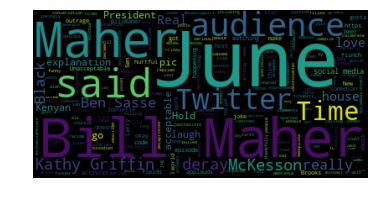

In [30]:
# Start with one review:
text = df.text[20000]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
df[:10]

,id,title,author,text,label,text_len,word_count
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4940,820
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160,710
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7714,1266
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3249,557
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1,942,154
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,1192,203
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,2735,489
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,4923,822
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,8177,1440
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0,10261,1736
